In [1]:
%pip install eyepop matplotlib pillow tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import asyncio
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm.notebook import tqdm
from eyepop import EyePopSdk, Job
from eyepop.worker.worker_types import Pop, InferenceComponent


In [ ]:
# Configuration
EYEPOP_SECRET_KEY = ""
MODEL_NAME = "workshop.voxel:1.0.0"
TEST_IMAGES_DIR = "Test Images"
RESULTS_DIR = "inference_results"

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"🔧 Configuration:")
print(f"   Model: {MODEL_NAME}")
print(f"   Test Images: {TEST_IMAGES_DIR}")
print(f"   Results Directory: {RESULTS_DIR}")

# Check if paths exist
print(f"\n🔍 Path Verification:")
print(f"   Current directory: {os.getcwd()}")
print(f"   Test Images exists: {os.path.exists(TEST_IMAGES_DIR)}")
print(f"   Results directory: {os.path.exists(RESULTS_DIR)}")

if os.path.exists(TEST_IMAGES_DIR):
    files = [f for f in os.listdir(TEST_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    print(f"   Found {len(files)} image files")
else:
    print(f"   ❌ Test images directory not found!")


🔧 Configuration:
   Model: workshop.voxel:1.0.0
   Test Images: Test Images
   Results Directory: inference_results

🔍 Path Verification:
   Current directory: /Users/sharozjavaid/Desktop/voxeltest/Voxel51-Medical-Workshop/notebooks
   Test Images exists: True
   Results directory: True
   Found 10 image files


In [4]:
def visualize_results(image_path: str, result: dict):
    """Visualize detection results on the image"""
    
    # Load image
    img = Image.open(image_path)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    
    # Draw bounding boxes if objects detected
    if 'objects' in result and result['objects']:
        for obj in result['objects']:
            x = obj.get('x', 0)
            y = obj.get('y', 0)
            width = obj.get('width', 0)
            height = obj.get('height', 0)
            confidence = obj.get('confidence', 0)
            label = obj.get('classLabel', 'unknown')
            
            # Create rectangle
            rect = patches.Rectangle(
                (x, y), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add label
            ax.text(
                x, y - 5, f"{label}: {confidence:.3f}",
                fontsize=10, color='red', weight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
            )
    
    ax.set_title(f"Inference Results: {os.path.basename(image_path)}", fontsize=14, weight='bold')
    ax.axis('off')
    
    # Save visualization
    output_path = os.path.join(RESULTS_DIR, f"{Path(image_path).stem}_visualization.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"📊 Visualization saved to: {output_path}")
    
    plt.show()


In [5]:
async def test_workshop_voxel(image_path: str, show_results: bool = True):
    """Test the workshop.voxel model with a specific image"""
    
    if not os.path.exists(image_path):
        print(f"❌ Image file not found: {image_path}")
        return None
    
    print(f"🧪 Testing workshop.voxel model with: {os.path.basename(image_path)}")
    
    # Create pop configuration with workshop.voxel model
    pop_config = Pop(
        components=[
            InferenceComponent(
                model="workshop.voxel:1.0.0"
            )
        ]
    )
    
    try:
        async with EyePopSdk.workerEndpoint(
            pop_id="transient",  
            secret_key=EYEPOP_SECRET_KEY,
            is_async=True,
        ) as endpoint:
            
            # Set the pop configuration
            await endpoint.set_pop(pop_config)
            print("✅ Pop configuration set successfully")
            
            # Upload and process the image
            print(f"📤 Uploading {os.path.basename(image_path)}...")
            job = await endpoint.upload(image_path)
            print("✅ Image uploaded successfully")
            
            # Get predictions
            print("🔮 Getting predictions...")
            result = await job.predict()
            
            if result:
                print("🎯 RESULTS:")
                print("=" * 60)
                
                # Save raw results to file
                result_file = os.path.join(RESULTS_DIR, f"{Path(image_path).stem}_results.json")
                with open(result_file, 'w') as f:
                    json.dump(result, f, indent=2)
                print(f"💾 Raw results saved to: {result_file}")
                
                # Print UNFILTERED summary - shows ALL detections (heart_region + stenosis)
                print("📦 UNFILTERED RESULTS (All Detections):")
                if 'objects' in result and result['objects']:
                    print(f"📦 Total objects detected: {len(result['objects'])}")
                    for i, obj in enumerate(result['objects']):
                        conf = obj.get('confidence', 0)
                        label = obj.get('classLabel', 'unknown')
                        bbox = f"({obj.get('x', 0):.0f}, {obj.get('y', 0):.0f}, {obj.get('width', 0):.0f}, {obj.get('height', 0):.0f})"
                        print(f"   {i+1}. {label}: {conf:.4f} - bbox: {bbox}")
                else:
                    print("📦 No objects detected")
                
                if 'classes' in result and result['classes']:
                    print(f"🏷️ Classifications: {len(result['classes'])}")
                    for i, cls in enumerate(result['classes']):
                        print(f"   {i+1}. {cls.get('classLabel', 'unknown')}: {cls.get('confidence', 0):.4f}")
                
                if 'segments' in result and result['segments']:
                    print(f"🎨 Segments: {len(result['segments'])}")
                
                print("=" * 60)
                
                # Visualize results if requested
                if show_results:
                    visualize_results(image_path, result)
                
                return result
            else:
                print("⚠️ No results returned")
                return None
                
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None


In [6]:
# Get list of test images
test_images = []
if os.path.exists(TEST_IMAGES_DIR):
    for file in os.listdir(TEST_IMAGES_DIR):
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            test_images.append(os.path.join(TEST_IMAGES_DIR, file))
    
    test_images.sort()
    print(f"📋 Found {len(test_images)} test images:")
    for i, img in enumerate(test_images, 1):
        print(f"   {i}. {os.path.basename(img)}")
else:
    print(f"❌ Test images directory not found: {TEST_IMAGES_DIR}")
    test_images = []


📋 Found 10 test images:
   1. 0688195a05f379d28000ea93b3ccc25b.jpg
   2. 0688195a05ff715b8000bde970e73d44.jpg
   3. 0688195a5d57720e8000d5744aca57f9.jpg
   4. 0688195a5d777a3b8000b95ffe74365a.jpg
   5. 0688195a5dad7ecf80000dd8f1eca3e4.jpg
   6. 0688195a5e06725c80007580b1e812fd.jpg
   7. 0688195a5efd7339800096dc609f493c.jpg
   8. 0688195a5f1575298000c5740bf08f65.jpg
   9. 0688195a6b737f3c8000642e2824bc62.jpg
   10. 0688195a6ba071d98000d43f6d113136.jpg


🧪 Testing single image: 0688195a05f379d28000ea93b3ccc25b.jpg
🧪 Testing workshop.voxel model with: 0688195a05f379d28000ea93b3ccc25b.jpg
✅ Pop configuration set successfully
📤 Uploading 0688195a05f379d28000ea93b3ccc25b.jpg...
✅ Image uploaded successfully
🔮 Getting predictions...
🎯 RESULTS:
💾 Raw results saved to: inference_results/0688195a05f379d28000ea93b3ccc25b_results.json
📦 UNFILTERED RESULTS (All Detections):
📦 Total objects detected: 4
   1. heart_region: 0.8685 - bbox: (264, 181, 55, 131)
   2. heart_region: 0.8413 - bbox: (196, 130, 82, 66)
   3. heart_region: 0.8330 - bbox: (105, 128, 86, 31)
   4. heart_region: 0.7109 - bbox: (300, 307, 57, 136)
📊 Visualization saved to: inference_results/0688195a05f379d28000ea93b3ccc25b_visualization.png


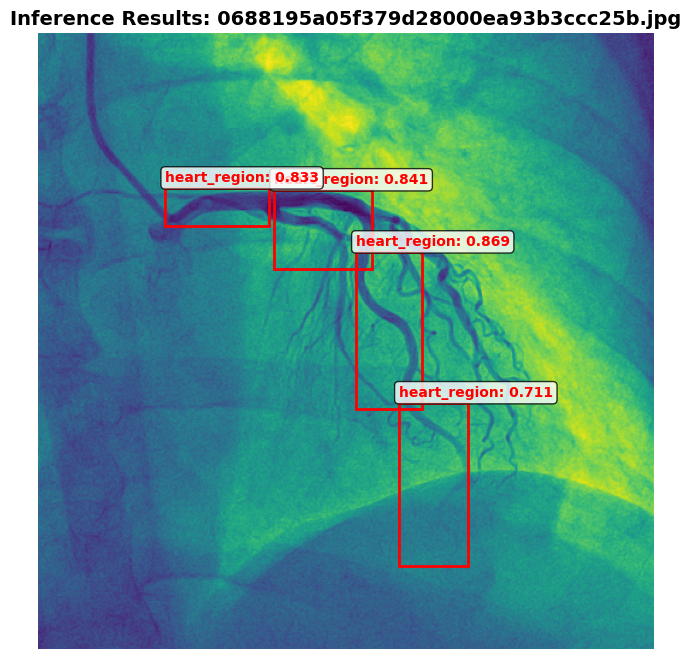

In [7]:
# Test a single image (run this cell to test one image)
if test_images:
    # Test the first image
    sample_image = test_images[0]
    print(f"🧪 Testing single image: {os.path.basename(sample_image)}")
    result = await test_workshop_voxel(sample_image, show_results=True)


In [8]:
# Test all images (run this cell to test all images)
async def test_all_images():
    """Test all images and collect results"""
    
    all_results = {}
    
    print(f"🚀 Starting batch inference on {len(test_images)} images...\n")
    
    for i, image_path in enumerate(test_images):
        print(f"\n{'='*80}")
        print(f"Processing image {i+1}/{len(test_images)}: {os.path.basename(image_path)}")
        print(f"{'='*80}")
        
        result = await test_workshop_voxel(image_path, show_results=False)
        
        if result:
            all_results[os.path.basename(image_path)] = result
            
            # COMMENTED OUT: Quick summary (filtering disabled)
            # obj_count = len(result.get('objects', []))
            # cls_count = len(result.get('classes', []))
            # print(f"✅ Summary: {obj_count} objects, {cls_count} classifications")
            print(f"✅ Processed successfully - raw results saved")
        else:
            print(f"❌ Failed to process {os.path.basename(image_path)}")
        
        print(f"\n⏱️ Progress: {i+1}/{len(test_images)} completed")
    
    # Save batch results
    batch_results_file = os.path.join(RESULTS_DIR, "batch_results_summary.json")
    with open(batch_results_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\n🎉 Batch processing completed!")
    print(f"📊 Results saved to: {batch_results_file}")
    
    return all_results

# Uncomment the line below to run batch inference
batch_results = await test_all_images()


🚀 Starting batch inference on 10 images...


Processing image 1/10: 0688195a05f379d28000ea93b3ccc25b.jpg
🧪 Testing workshop.voxel model with: 0688195a05f379d28000ea93b3ccc25b.jpg
✅ Pop configuration set successfully
📤 Uploading 0688195a05f379d28000ea93b3ccc25b.jpg...
✅ Image uploaded successfully
🔮 Getting predictions...
🎯 RESULTS:
💾 Raw results saved to: inference_results/0688195a05f379d28000ea93b3ccc25b_results.json
📦 UNFILTERED RESULTS (All Detections):
📦 Total objects detected: 4
   1. heart_region: 0.8685 - bbox: (264, 181, 55, 131)
   2. heart_region: 0.8413 - bbox: (196, 130, 82, 66)
   3. heart_region: 0.8330 - bbox: (105, 128, 86, 31)
   4. heart_region: 0.7109 - bbox: (300, 307, 57, 136)
✅ Processed successfully - raw results saved

⏱️ Progress: 1/10 completed

Processing image 2/10: 0688195a05ff715b8000bde970e73d44.jpg
🧪 Testing workshop.voxel model with: 0688195a05ff715b8000bde970e73d44.jpg
✅ Pop configuration set successfully
📤 Uploading 0688195a05ff715b8000bde970e73d44.jp